In [ ]:
from datetime import datetime
import random 
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import make_scorer 
import matplotlib.pyplot as plt
import gensim.downloader as api

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from google.colab import drive
drive.mount('/content/gdrive')
dir_name = "/content/gdrive/MyDrive/Thesis/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/gdrive


In [ ]:
def get_raw_data(dir_name):
    #  load data
    data = pd.read_csv('{}cancer_doc_classification.csv'.format(dir_name), encoding = 'latin-1', usecols=['a', '0'])
    data = data.rename(columns={'0': 'label', 'a': 'text'})
    le = LabelEncoder()
    data['label'] = le.fit_transform( data['label'])
    return data

raw_data = get_raw_data(dir_name + 'datasets/')
raw_data

,label,text
0,2,Thyroid surgery in children in a single insti...
1,2,""" The adopted strategy was the same as that us..."
2,2,coronary arterybypass grafting thrombosis ï¬b...
3,2,Solitary plasmacytoma SP of the skull is an u...
4,2,This study aimed to investigate serum matrix ...
...,...,...
7565,0,we report the case of a 24yearold man who pres...
7566,0,among synchronous colorectal cancers scrcs rep...
7567,0,the heterogeneity of cancer cells is generally...
7568,0,"""adipogenesis is the process through which mes..."


In [ ]:
raw_data['text'].is_unique

False

In [ ]:
raw_data.drop_duplicates( inplace=True)
raw_data['text'].is_unique

True

In [ ]:
raw_data

,label,text
0,2,Thyroid surgery in children in a single insti...
1,2,""" The adopted strategy was the same as that us..."
2,2,coronary arterybypass grafting thrombosis ï¬b...
3,2,Solitary plasmacytoma SP of the skull is an u...
4,2,This study aimed to investigate serum matrix ...
...,...,...
6863,1,"""Missense mutation distribution in the exons a..."
6929,1,"""versus gemcitabine/carboplatin in advanced no..."
7040,2,Keloids are pathological scars that grow over...
7485,0,the anization of cells into multiple membranou...


In [ ]:
def get_dataset_statistics(data):
    dataset_statistics = {'Number of messages': [data['label'].value_counts()[0], data['label'].value_counts()[1], data['label'].value_counts()[2]]}
    df = pd.DataFrame(dataset_statistics, index=['0', '1', '2'])
    df.plot(kind='pie', y='Number of messages', figsize=(6, 6), fontsize=14,
            autopct=lambda v: '{:.0f} ({:.1f}%)'.format(v / 100 * data['label'].count(), v))

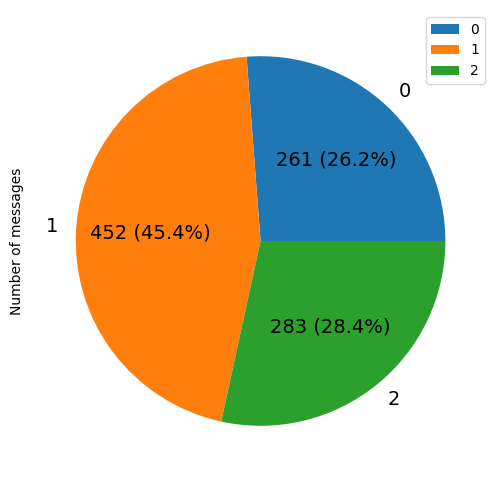

In [ ]:
get_dataset_statistics(raw_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(raw_data['text'].to_numpy(), raw_data['label'].to_numpy(), stratify=raw_data['label'].to_numpy(), test_size=0.2, random_state=24)

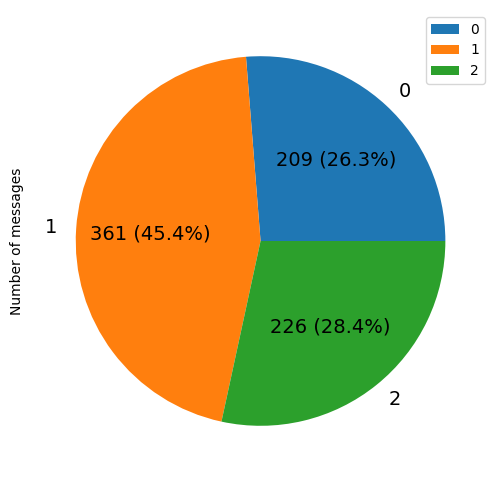

In [ ]:
get_dataset_statistics(pd.DataFrame({'label': y_train}))

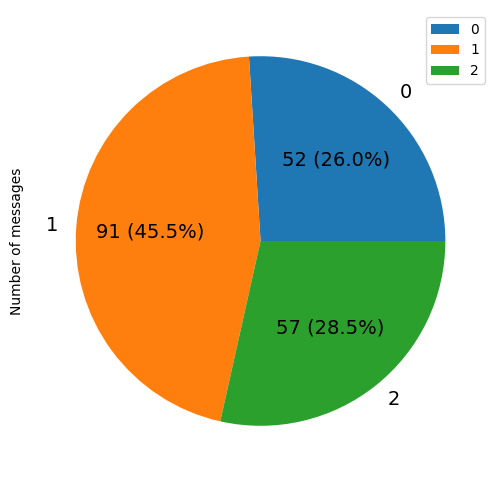

In [ ]:
get_dataset_statistics(pd.DataFrame({'label': y_test}))

In [ ]:
train_data = pd.DataFrame({'text': X_train, 'label': y_train})

train_data

,text,label
0,in a novel coronavirus sarscov2 was found to ...,0
1,""" the incidence of thyroid carcinoma is incre...",0
2,Sequential Use of aYeastCEA Therapeutic Cancer...,2
3,Paired box protein8 PAX8 immunohistochemical e...,2
4,Is preoperative heart rate variability aprogn...,2
...,...,...
791,"""widely usedcancerspecific questionnaire asses...",2
792,"""Thus mathematical models that can estimate lo...",1
793,"""Trophoblast cell surface antigen TROP2 is ov...",2
794,overexpression of epithelial cell adhesion mol...,0


In [ ]:
test_data = pd.DataFrame({'text': X_test, 'label': y_test})

test_data

,text,label
0,"""A decrease of 50% or more from baseline urina...",1
1,"""The remaining 24 (25.3%) were not differentia...",1
2,"""Results Exceptional response to an IGF-1R inh...",1
3,"""detection and quantification of cancer DNA mo...",1
4,"""1.3±0.4 cm (range: 0.7-2.0 cm) for Group A an...",1
...,...,...
195,""" heat shock transcription factor1 hsf1 was o...",0
196,"""fundamental influences of sex and gender...",2
197,Activation by NaturalPhytochemicals An Overvie...,2
198,"""Effects of lowdose computed tomography LDCT s...",2


# Text Preprocessing 

In [ ]:
import requests
stopwords_list = requests.get("https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [ ]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = ENGLISH_STOP_WORDS

stop_words = set(stopwords.words('english'))
stop_words.update(sklearn_stopwords)

def text_preprocessing(raw_text):
  text_words = raw_text.translate(str.maketrans('', '', string.punctuation))
  msg_tokens = word_tokenize(text_words.lower())
  filtered_text = [token for token in msg_tokens if not token in stop_words]
  return " ".join(filtered_text)

In [ ]:
train_data = train_data[['text', 'label']].copy()

train_data['text'] = train_data['text'].apply(text_preprocessing)

train_data.drop_duplicates(inplace=True)

train_data

,text,label
0,novel coronavirus sarscov2 cause highly contag...,0
1,incidence thyroid carcinoma increasing world s...,0
2,sequential use ayeastcea therapeutic cancervac...,2
3,paired box protein8 pax8 immunohistochemical e...,2
4,preoperative heart rate variability aprognosti...,2
...,...,...
791,widely usedcancerspecific questionnaire assess...,2
792,mathematical models estimate longterm costeffe...,1
793,trophoblast cell surface antigen trop2 overexp...,2
794,overexpression epithelial cell adhesion molecu...,0


In [ ]:
test_data = test_data[['text', 'label']].copy()

test_data['text'] = test_data['text'].apply(text_preprocessing)

test_data.drop_duplicates(inplace=True)

test_data

,text,label
0,decrease 50 baseline urinary prostaglandin e2 ...,1
1,remaining 24 253 differentiated nsclc nos medi...,1
2,results exceptional response igf1r inhibitor 5...,1
3,detection quantification cancer dna molecules ...,1
4,13±04 cm range 0720 cm group 06±03 cm range 03...,1
...,...,...
195,heat shock transcription factor1 hsf1 overexpr...,0
196,fundamental influences sex gender modifiers ma...,2
197,activation naturalphytochemicals overviewconce...,2
198,effects lowdose computed tomography ldct scree...,2


# Feature Extraction

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_text_vec(sent):
  vector = np.mean(np.array([word2vec_model[token] for token in word_tokenize(sent) if token in word2vec_model.key_to_index]), axis=0)
  if np.all(np.isnan(vector)) :
    return np.zeros(300)
  return vector

In [ ]:
X_test = np.stack(np.array([get_text_vec(text) for text in test_data['text'].values]))

In [ ]:
X_test.shape

(200, 300)

In [ ]:
y_test = test_data['label'].values

In [ ]:
y_test.shape

(200,)

# Model selection, training and evaluation

In [ ]:
def f_beta_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2, average='macro')

f2_score = make_scorer(f_beta_score, greater_is_better=True)

In [ ]:
from datetime import datetime

def save_cross_validation(results, file_name):
  results_to_save = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'F2 Score'])
  for i in range(0, 10):
    results_to_save.loc[i] = [
      results['split{}_test_Accuracy'.format(i)][0],
      results['split{}_test_Recall'.format(i)][0],
      results['split{}_test_Precision'.format(i)][0],
      results['split{}_test_F1'.format(i)][0],
      results['split{}_test_F2'.format(i)][0]
    ]
  results_to_save.to_csv('{}Results/{}_{}.csv'.format(dir_name+'experiments/Cancer Doc/', file_name, datetime.now().strftime("%m%d%H%M")))

In [ ]:
def train_model(classifier, param_grid, model_name, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    """
    train email classification model.
    """

    # apply grid search to find best model hyper parameters
    grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring={'Accuracy': make_scorer(accuracy_score),
                                                                       'F1': make_scorer(f1_score, average='macro'),
                                                                       'F2': f2_score,
                                                                       'Recall': make_scorer(recall_score, average='macro'),
                                                                       'Precision': make_scorer(precision_score, average='macro')
                                                                       }, refit='F1', n_jobs=-1)
    grid_search.fit(train_texts, train_labels)
    model = grid_search.best_estimator_

    if to_save:
      ConfusionMatrixDisplay(save_cross_validation(grid_search.cv_results_, file_name))
      plt.show()

    # train and test accuracy.
    test_accuracy = model.score(test_texts, test_labels)
    train_accuracy = model.score(train_texts, train_labels)

    # compute F1 score for model evaluation.
    y_pred = model.predict(test_texts)

    recall = recall_score(test_labels, y_pred, average='macro')
    precision = precision_score(test_labels, y_pred, average='macro')
    f1score = f1_score(test_labels, y_pred, average='macro')
    f2score = fbeta_score(y_test, y_pred, beta=2, average='macro')

    if to_print:
        print("train accuracy = " + str(train_accuracy))
        print("test accuracy = " + str(test_accuracy))
        print("Recall = {}".format(recall))
        print("Precision = {}".format(precision))
        print("F1 score = {}".format(f1score))
        print("F2 score = {}".format(f2score))
        print(classification_report(test_labels, y_pred))


        # plot confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])

        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # print best model hyper parameters.
        print(grid_search.best_params_)

    evaluation_metrics.loc[model_name, 'Recall'] = recall
    evaluation_metrics.loc[model_name, 'Precision'] = precision
    evaluation_metrics.loc[model_name, 'F1 score'] = f1score
    evaluation_metrics.loc[model_name, 'F2 score'] = f2score

    return f1score, f2score


def train(model_id, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    
    if model_id == 1:
        # Random forest Classification model.
        forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
        # forest_param_grid = [{'n_estimators': [25, 50, 75], 'max_features': [10, 15, 20, 25, 30], 'min_samples_split': [15, 20, 25], 'criterion': ['gini','entropy'], 'max_depth': [4,5]}]
        forest_param_grid = [{'n_estimators': [50, 75, 100, 150, 200], 'max_features': [8, 9, 10], 'min_samples_split': [25, 30], 'criterion': ['gini','entropy'], 'max_depth': [4, 5]}]

        return train_model(forest_clf, forest_param_grid, 'RandomForest', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

    if model_id == 2:
        # Support Vector Machine Model.
        svc_clf = SVC(random_state=42)
        svc_param_grid = [{'kernel': ['rbf', 'poly'], 'degree': [2, 3 ,4, 5]}]

        return train_model(svc_clf, svc_param_grid, 'SVM', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

#Text Aug.

In [ ]:
from nltk.corpus import wordnet

def get_synonyms(word):
  synonyms = []
  for synonym in wordnet.synsets(word):
    for lemma in [l.name().lower() for l in synonym.lemmas()]:
      if len(lemma.split('_')) == 1 and lemma != word:
        synonyms.append(lemma)

  return list(set(synonyms))

In [ ]:
import itertools

def get_sentence_augmentations(sentence, similarity_threshold=.75):
  sentence_tokens = word_tokenize(sentence.lower())
  new_sentences = []
  words = []
  all_synonyms = []
  for word in sentence_tokens:
    if word in word2vec_model.key_to_index :
      synonyms = get_synonyms(word)
      if len(synonyms) > 0:
        good_synonyms = []
        for synonym in synonyms:
          if synonym in word2vec_model.key_to_index :
            if word2vec_model.similarity(word, synonym) >= similarity_threshold:
              good_synonyms.append(synonym)
        if len(good_synonyms) > 0:
          words.append(word)
          good_synonyms.append(word)
          all_synonyms.append(good_synonyms)
  for product in itertools.product(*all_synonyms):
    new_sentence = sentence
    for src, dest in zip(words, product):
        new_sentence = new_sentence.replace("%s" % src, dest)
    new_sentences.append(new_sentence.lower())
    # new_sentences.remove(sentence)
  return new_sentences

In [ ]:
def my_augmentation(prepro_dataset, lable, similarity_threshold=.75):
  texts = prepro_dataset.loc[prepro_dataset['label'] == lable]['text'].values
  texts_num = len(texts)
  new_texts = []
  i = 0
  
  for text in texts:
    new_texts.extend(get_sentence_augmentations(text, similarity_threshold))
    if i % 20 == 0:
      print(f" {int(100*i/texts_num)} %")
    i += 1
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
  augmentations.drop_duplicates(inplace=True)
  return augmentations.sample(frac=1)

In [ ]:
augmented_dataset = my_augmentation(train_data, lable=0, similarity_threshold=.9)

 0 %
 9 %
 19 %
 28 %
 38 %
 47 %
 57 %
 66 %
 76 %
 86 %
 95 %


<ipython-input-21-98b0f6d823b3>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)


In [ ]:
augmented_dataset = my_augmentation(augmented_dataset, lable=2, similarity_threshold=.9)

 0 %
 8 %
 17 %
 26 %
 35 %
 44 %
 53 %
 61 %
 70 %
 79 %
 88 %
 97 %


<ipython-input-21-98b0f6d823b3>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)


In [ ]:
augmented_dataset

,text,label
267,cyskpeg1110mercoch32 peptide 30 mg 068 mol pro...,1
3159,mukonal active member carbazole alkaloids isol...,2
91,primary squamous cell carcinoma ofis anextreme...,2
178,luteoloside exerts inhibitory effect prolifera...,1
548,fraction needed photon plans translates beam t...,1
...,...,...
311,posterior reversible encephalopathy syndrome p...,0
431,99mtclabeled nanocolloid drugs development me...,2
705,logrank test determined pfs os high klk11 grou...,1
218,gatekeeper t790m mutation 34 monotherapy mutan...,1


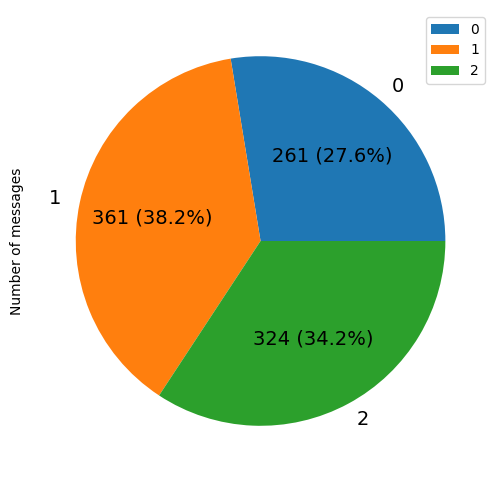

In [ ]:
get_dataset_statistics(augmented_dataset)

In [ ]:
aug_X_train = np.stack(np.array([get_text_vec(sms_text) for sms_text in augmented_dataset['text'].values]))

In [ ]:
aug_X_train.shape

(946, 300)

In [ ]:
aug_y_train = augmented_dataset['label'].values

In [ ]:
aug_y_train.shape

(946,)

In [ ]:
evaluation_metrics_aug = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])


#Random Forest
Similarity threshold .9

train accuracy = 0.8942917547568711
test accuracy = 0.725
Recall = 0.6575573549257759
Precision = 0.6802282270079912
F1 score = 0.6443254601149339
F2 score = 0.6486237475420432
              precision    recall  f1-score   support

           0       0.62      0.29      0.39        52
           1       0.85      1.00      0.92        91
           2       0.57      0.68      0.62        57

    accuracy                           0.73       200
   macro avg       0.68      0.66      0.64       200
weighted avg       0.71      0.72      0.70       200



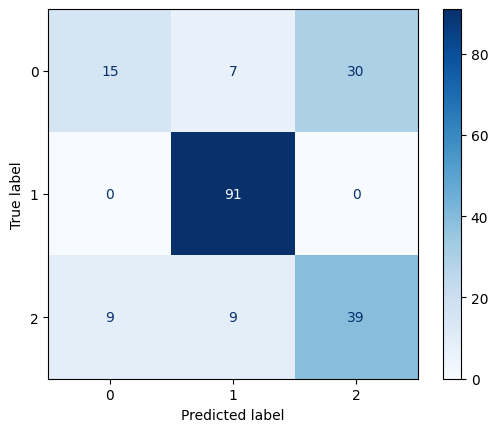

{'criterion': 'gini', 'max_depth': 5, 'max_features': 20, 'min_samples_split': 15, 'n_estimators': 50}


(0.6443254601149339, 0.6486237475420432)

In [ ]:
train(1, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='TAMS_RF')

# SVM
Similarity threshold .9

train accuracy = 0.8181818181818182
test accuracy = 0.735
Recall = 0.6730608572713835
Precision = 0.6889090699417633
F1 score = 0.6545589133245324
F2 score = 0.6610057592699636
              precision    recall  f1-score   support

           0       0.58      0.27      0.37        52
           1       0.95      0.98      0.96        91
           2       0.54      0.77      0.63        57

    accuracy                           0.73       200
   macro avg       0.69      0.67      0.65       200
weighted avg       0.74      0.73      0.71       200



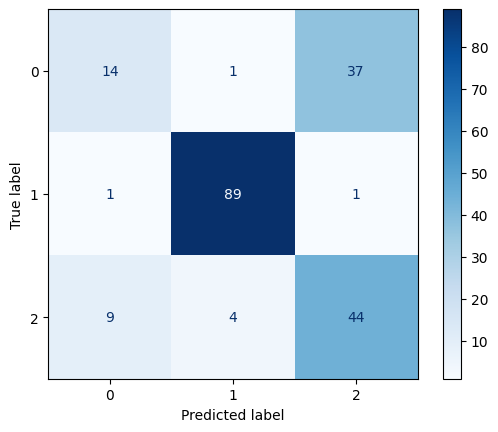

{'degree': 5, 'kernel': 'poly'}


(0.6545589133245324, 0.6610057592699636)

In [ ]:
train(2, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='TAMS_SVM')

In [ ]:
evaluation_metrics_aug

,Recall,Precision,F1 score,F2 score
SVM,0.673061,0.688909,0.654559,0.661006
RandomForest,0.677206,0.688912,0.677601,0.676275


#BiLSTM
Similarity threshold .9

In [ ]:
import random
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedKFold

In [ ]:
def create_blstm_model(train_texts):

  vectorize_layer = layers.TextVectorization(max_tokens=50000, output_sequence_length=2000)

  vectorize_layer.adapt(train_texts)

  embedding_layer = layers.Embedding(input_dim=50000, output_dim=100, input_length=2000)

  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
  model.add(vectorize_layer)
  model.add(embedding_layer)

  model.add(layers.Bidirectional(layers.LSTM(40, bias_regularizer=regularizers.L2(1e-2), kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), activity_regularizer=regularizers.L2(1e-2))))
  model.add(Dropout(0.2))
  model.add(layers.Dense(3, activation='softmax'))


  model.compile(optimizer=keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])  
  print(model.summary())
  
  return model

# Cross Validation

In [ ]:
def cv_blstm():

  kf = StratifiedKFold(10, shuffle=True, random_state=42) 
  cv_metrics = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

  fold = 0

  X = augmented_dataset['text'].values
  Y = augmented_dataset['label'].values

  for train, val in kf.split(X, Y):  
  
    print(f"Fold {fold}")

    train_texts = X[train]
    train_labels = Y[train]
    test_texts = X[val]
    test_labels = Y[val]

    blstm_model = create_blstm_model(train_texts)

    history = blstm_model.fit(train_texts,
                              train_labels,
                              epochs=10,
                              batch_size=16,
                              validation_data=(test_texts, test_labels))

    blstm_model.evaluate(test_texts, test_labels)
    y_pred = np.round(blstm_model.predict(test_texts))
    y_pred = np.argmax(y_pred, axis=1)

    f1_sc = f1_score(test_labels, y_pred, average='macro')
    f2score = fbeta_score(test_labels, y_pred, beta=2, average='macro')

    cv_metrics.loc[fold, 'Recall'] = recall_score(test_labels, y_pred, average='macro')
    cv_metrics.loc[fold, 'Precision'] = precision_score(test_labels, y_pred, average='macro')
    cv_metrics.loc[fold, 'F1 score'] = f1_sc
    cv_metrics.loc[fold, 'F2 score'] = f2score
    
    fold += 1

  return cv_metrics

In [ ]:
cv_results = cv_blstm()

Fold 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 2000)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 2000, 100)         5000000   
                                                                 
 bidirectional (Bidirectiona  (None, 80)               45120     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 3)                 243       
                                                                 
Total params: 5,045,363
Trainable params: 5,045,3

3/3 [==============================] - 1s 46ms/step
Fold 5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (TextV  (None, 2000)             0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 2000, 100)         5000000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 80)               45120     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 80)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 243       
                                                             

3/3 [==============================] - 2s 93ms/step
Fold 6
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 2000)             0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 2000, 100)         5000000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 80)               45120     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 80)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 243       
                                                             

In [ ]:
cv_results

,Recall,Precision,F1 score,F2 score
0,0.786664,0.787634,0.784323,0.785014
1,0.792438,0.799452,0.79318,0.792073
2,0.725589,0.738406,0.728039,0.725572
3,0.742165,0.741111,0.7402,0.741027
4,0.823686,0.840049,0.80936,0.812577
5,0.843952,0.843155,0.843085,0.843489
6,0.797009,0.809195,0.794834,0.793932
7,0.782853,0.780075,0.77988,0.781302
8,0.772436,0.786935,0.770847,0.769872
9,0.806357,0.817037,0.801014,0.801397


In [ ]:
cv_results.mean()

Recall       0.787315
Precision    0.794305
F1 score     0.784476
F2 score     0.784625
dtype: float64

In [ ]:
def train_blstm(train_texts, train_labels, test_texts, test_labels):

  blstm_model = create_blstm_model(train_texts)
  
  history = blstm_model.fit(train_texts,
                            train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(test_texts, test_labels))
  
  blstm_model.evaluate(test_texts, test_labels)
  y_pred = np.round(blstm_model.predict(test_texts))

  y_pred = np.argmax(y_pred, axis=1)

  f1_sc = f1_score(test_labels, y_pred, average='macro')
  f2score = fbeta_score(test_labels, y_pred, beta=2, average='macro')

  print("Recall = {}".format(recall_score(test_labels, y_pred, average='macro')))
  print("Precision = {}".format(precision_score(test_labels, y_pred, average='macro')))
  print("F1 score = {}".format(f1_sc))
  print("F2 score = {}".format(f2score))
  print(classification_report(test_labels, y_pred))
  
  cm = confusion_matrix(test_labels, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  return f1_sc

In [ ]:
X_test = test_data['text'].values.reshape(-1, 1)

In [ ]:
y_test = test_data['label'].values

In [ ]:
aug_X_train = augmented_dataset['text'].values.reshape(-1, 1)

In [ ]:
aug_X_train.shape

(946, 1)

In [ ]:
aug_y_train = augmented_dataset['label'].values.reshape(-1, 1)

In [ ]:
aug_y_train.shape

(946, 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 2000)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 2000, 100)         5000000   
                                                                 
 bidirectional (Bidirectiona  (None, 80)               45120     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 3)                 243       
                                                                 
Total params: 5,045,363
Trainable params: 5,045,363
Non-

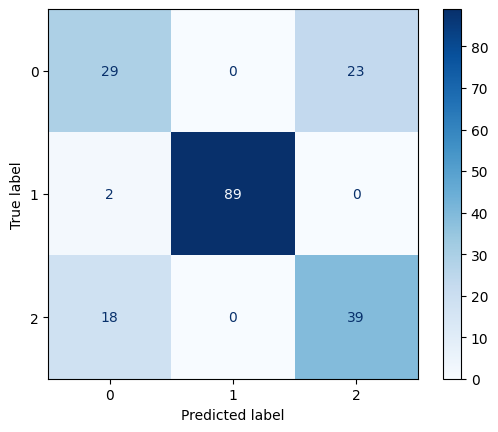

0.7395361665018042

In [ ]:
train_blstm(aug_X_train, aug_y_train, X_test, y_test)